# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance

We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model





In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

# 1. Exploring The Data

In [2]:
DATA_FILENAME = "insurance.csv"

In [3]:
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Number of rows in the dataset
num_rows = len(dataframe)
print(num_rows)

1338


In [5]:
# number of columns in the dataset
num_cols = len(dataframe.columns)
print(num_cols)

7


In [6]:
# column titles of the input
input_cols = list(dataframe.drop('charges',axis=1).columns)
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

In [7]:
# input columns that are non-numeric / categorial variables
categorical_cols = list(dataframe.select_dtypes(include="object").columns)
categorical_cols

['sex', 'smoker', 'region']

In [8]:
# column title of output/target variables
output_cols = [dataframe.columns[-1]]
output_cols

['charges']

In [9]:
#minimum, maximum and average value of the "charges" column
import numpy as np

min_charge = dataframe.charges.min()

max_charge = dataframe.charges.max()

avg_charge = dataframe.charges.mean()

print(f"Minimum charge: {min_charge}")
print(f"Maximum charge: {max_charge}")
print(f"Average charge: {avg_charge}")

Minimum charge: 1121.8739
Maximum charge: 63770.42801
Average charge: 13270.422265141257


### the distribution of 'charge' values in a graph

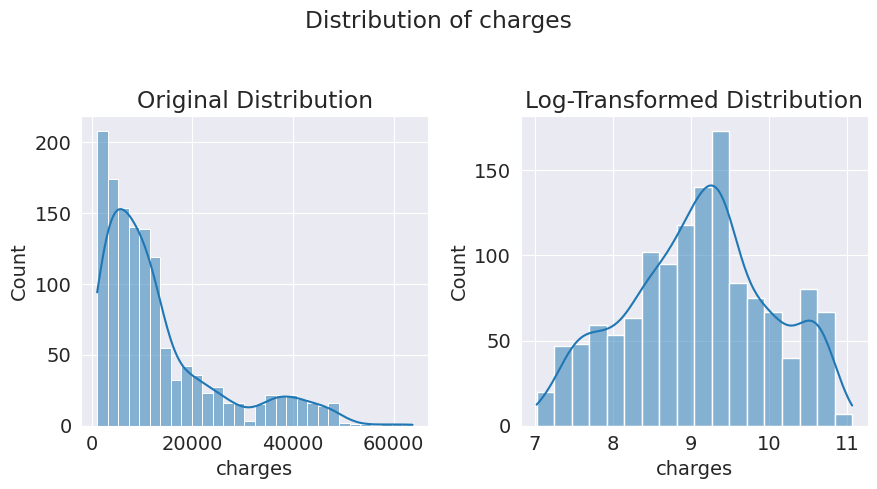

In [10]:
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)

fig, axs = plt.subplots(ncols=2)
fig.suptitle("Distribution of charges")

# Plot original distribution
sns.histplot(dataframe.charges, kde=True, ax=axs[0])
axs[0].set_title("Original Distribution")

# Plot log-transformed distribution
sns.histplot(np.log(dataframe.charges), kde=True, ax=axs[1])
axs[1].set_title("Log-Transformed Distribution")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for suptitle
plt.show()


# 2. Prepare the dataset for training

we need to convert the data from the pandas dataframe into pyTorch tensorsfor training

in order to do this we need first to convert it to numpy arrays

In [11]:
def dataframe_to_arrays(dataframe):
  # Copy of the original dataframe
  dataframe1 = dataframe.copy()
  # convert non-numeric categorical columns into numbers
  for col in categorical_cols :
    dataframe1[col] = dataframe1[col].astype('category').cat.codes
  # Extract input & outputs & targets as numpy arrays
  inputs_array = np.array(dataframe1[input_cols])
  targets_array = np.array(dataframe1[output_cols])
  return inputs_array, targets_array


In [12]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
print(inputs_array.shape, targets_array.shape)
inputs_array, targets_array

(1338, 6) (1338, 1)


(array([[19.  ,  0.  , 27.9 ,  0.  ,  1.  ,  3.  ],
        [18.  ,  1.  , 33.77,  1.  ,  0.  ,  2.  ],
        [28.  ,  1.  , 33.  ,  3.  ,  0.  ,  2.  ],
        ...,
        [18.  ,  0.  , 36.85,  0.  ,  0.  ,  2.  ],
        [21.  ,  0.  , 25.8 ,  0.  ,  0.  ,  3.  ],
        [61.  ,  0.  , 29.07,  0.  ,  1.  ,  1.  ]]),
 array([[16884.924 ],
        [ 1725.5523],
        [ 4449.462 ],
        ...,
        [ 1629.8335],
        [ 2007.945 ],
        [29141.3603]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors.

In [13]:
# Important data type float32
inputs = torch.from_numpy(inputs_array).to(torch.float32)
targets = torch.from_numpy(targets_array).to(torch.float32)

In [14]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [15]:
print(inputs, targets)

tensor([[19.0000,  0.0000, 27.9000,  0.0000,  1.0000,  3.0000],
        [18.0000,  1.0000, 33.7700,  1.0000,  0.0000,  2.0000],
        [28.0000,  1.0000, 33.0000,  3.0000,  0.0000,  2.0000],
        ...,
        [18.0000,  0.0000, 36.8500,  0.0000,  0.0000,  2.0000],
        [21.0000,  0.0000, 25.8000,  0.0000,  0.0000,  3.0000],
        [61.0000,  0.0000, 29.0700,  0.0000,  1.0000,  1.0000]]) tensor([[16884.9238],
        [ 1725.5522],
        [ 4449.4619],
        ...,
        [ 1629.8335],
        [ 2007.9449],
        [29141.3594]])


Creating Pytorch datasets & data loaders for traning & validation using `TensorDataset`

In [16]:
dataset = TensorDataset(inputs, targets)

using `random_split` to create training & validation datasets

In [17]:
validation_percent = 0.1
validation_size = int(num_rows * validation_percent)
print(validation_size)
train_size = num_rows - validation_size
print(train_size)

train_ds, validation_ds = random_split(dataset, [train_size, validation_size]) # Randomly splitting dataset  into 2 parts with desired length

133
1205


In [18]:
print(len(train_ds))
print(len(validation_ds))

1205
133


## Creating data loaders for training & validation(testing)

In [19]:
batch_size = 64 # most likely i will try 32 as well (i heard it enough from an old tutorial things may have changed now)

In [20]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
validation_loader = DataLoader(validation_ds, batch_size)

In [21]:
# cheking that batch of data is working
for xb, yb in train_loader:
  print("inputs:", xb)
  print("targets:", yb)
  break

inputs: tensor([[57.0000,  1.0000, 31.5400,  0.0000,  0.0000,  1.0000],
        [51.0000,  1.0000, 42.9000,  2.0000,  1.0000,  2.0000],
        [27.0000,  0.0000, 21.4700,  0.0000,  0.0000,  1.0000],
        [27.0000,  1.0000, 30.5000,  0.0000,  0.0000,  3.0000],
        [30.0000,  1.0000, 24.1300,  1.0000,  0.0000,  1.0000],
        [21.0000,  1.0000, 26.0300,  0.0000,  0.0000,  0.0000],
        [32.0000,  1.0000, 30.8000,  3.0000,  0.0000,  3.0000],
        [64.0000,  0.0000, 22.9900,  0.0000,  1.0000,  2.0000],
        [20.0000,  1.0000, 27.3000,  0.0000,  1.0000,  3.0000],
        [50.0000,  1.0000, 25.3650,  2.0000,  0.0000,  1.0000],
        [62.0000,  0.0000, 32.6800,  0.0000,  0.0000,  1.0000],
        [55.0000,  0.0000, 29.8300,  0.0000,  0.0000,  0.0000],
        [54.0000,  0.0000, 30.8000,  3.0000,  0.0000,  3.0000],
        [19.0000,  0.0000, 23.4000,  2.0000,  0.0000,  3.0000],
        [47.0000,  0.0000, 33.3450,  0.0000,  0.0000,  0.0000],
        [30.0000,  1.0000, 31.40

# 3. Create a Linear Regression

In [22]:
input_size = len(input_cols)
print(input_size)
output_size = len(output_cols)
print(output_size)


6
1


In [23]:
class InsuranceModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Single fully-connected layer that directly maps the inputs to outputs
    self.linear = nn.Linear(input_size, output_size)

  def forward(self, xb):
      out = self.linear(xb)
      return out

  def training_step(self, batch):
    inputs, targets = batch
    # Generate predictions
    out = self(inputs) # same as self.forward(inputs)
    # Calculate loss (using l1_loss function)
    loss = F.l1_loss(out, targets)
    return loss

  def validation_step(self, batch):
    inputs, targets = batch
    # Generate predictions
    out = self(inputs)
    # Calculate loss
    loss = F.l1_loss(out, targets)
    return {'val_loss': loss.detach()}

  def validation_epoch_end(self, outputs):
    # extract the 'val_loss' value from each dictionary in the outputs list.
    batch_losses = [x['val_loss'] for x in outputs]

    # torch.stack(batch_losses): This takes the list of individual batch loss tensors and stacks them into a single tensor.
    epoch_loss = torch.stack(batch_losses).mean() # Combine losses
    #.item(): This is used to get the standard Python number from the tensor
    return {'val_loss': epoch_loss.item()}

  def epoch_end(self, epoch, result, num_epochs):
    # Print result every 500th epoch
    if (epoch+1) % 500 == 0 or epoch == num_epochs-1:
      print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))



Creating it


In [24]:
model = InsuranceModel()

Checking out the weights and biases of the model using `model.parameters`

In [25]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2427, -0.2528,  0.0460,  0.0254,  0.3169, -0.1402]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0991], requires_grad=True)]

# 4. Train the model to fit the data

To train our model, i will use `fit` function  

In [26]:
def evaluate(model,validation_loader):
  outputs = [model.validation_step(batch) for batch in validation_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, validation_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    # Training phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation phase
    result = evaluate(model, validation_loader)
    model.epoch_end(epoch, result, epochs)
    history.append(result)
  return history


In [27]:
model = InsuranceModel()
result = evaluate(model, validation_loader)
print(result)

{'val_loss': 10762.8310546875}


Model now is ready to be trained. it might need to be runned on different numberof epochs with different learning rates to get good results (advice i have read) .

in a case of loss too large or `nan` i will need to reintialize  the model by running the cell `model = InsuranceModel()`

Training the model with different learning rates and for different number of epochs (FIGURING OUT)

In [28]:
epochs = 1000
lr = 0.001
history1 = fit(epochs, lr, model, train_loader, validation_loader)


Epoch [500], val_loss: 5284.4355
Epoch [1000], val_loss: 5057.6802


In [29]:
epochs = 1500
lr = 0.05
history2 = fit(epochs, lr, model, train_loader, validation_loader)

Epoch [500], val_loss: 4302.0034
Epoch [1000], val_loss: 4244.2954
Epoch [1500], val_loss: 4211.0298


In [30]:
epochs = 2000
lr = 0.1
history3 = fit(epochs, lr, model, train_loader, validation_loader)

Epoch [500], val_loss: 4161.9541
Epoch [1000], val_loss: 4148.3403
Epoch [1500], val_loss: 4101.4189
Epoch [2000], val_loss: 4045.7170


In [31]:
epochs = 2500
lr = 0.4
history4 = fit(epochs, lr, model, train_loader, validation_loader)

Epoch [500], val_loss: 3922.7273
Epoch [1000], val_loss: 3922.7900
Epoch [1500], val_loss: 3732.5645
Epoch [2000], val_loss: 3678.8792
Epoch [2500], val_loss: 3519.8904


In [32]:
epochs = 3000
lr = 0.8
history5 = fit(epochs, lr, model, train_loader, validation_loader)

Epoch [500], val_loss: 3503.9353
Epoch [1000], val_loss: 3244.7002
Epoch [1500], val_loss: 2971.5986
Epoch [2000], val_loss: 2763.0310
Epoch [2500], val_loss: 2896.2029
Epoch [3000], val_loss: 2563.6765


In [33]:
#  final validation loss of the model
val_loss = history5[-1]
val_loss

{'val_loss': 2563.676513671875}

# 5. Make predictions using the trained model

In [34]:
def predict_single(input,target,model):
  inputs = input.unsqueeze(0)
  predictions = model(inputs)
  prediction = predictions[0].detach()
  print("Input:", input)
  print("Target:", target)
  print("Prediction:", prediction)

In [35]:
input,target = validation_ds[0]
predict_single(input, target, model)

Input: tensor([44.0000,  0.0000, 43.8900,  2.0000,  1.0000,  2.0000])
Target: tensor([46200.9844])
Prediction: tensor([22657.4746])


In [36]:
input,target = validation_ds[10]
predict_single(input, target, model)

Input: tensor([26.0000,  1.0000, 32.4900,  1.0000,  0.0000,  0.0000])
Target: tensor([3490.5491])
Prediction: tensor([3992.0828])


In [37]:
input,target = validation_ds[13]
predict_single(input, target, model)

Input: tensor([50.0000,  0.0000, 27.3600,  0.0000,  0.0000,  0.0000])
Target: tensor([25656.5762])
Prediction: tensor([10279.3008])


In [38]:
input,target = validation_ds[54]
predict_single(input, target, model)

Input: tensor([20.0000,  0.0000, 28.7850,  0.0000,  0.0000,  0.0000])
Target: tensor([2457.2112])
Prediction: tensor([2492.1326])


In [39]:
input,target = validation_ds[87]
predict_single(input, target, model)

Input: tensor([49.0000,  0.0000, 34.7700,  1.0000,  0.0000,  1.0000])
Target: tensor([9583.8936])
Prediction: tensor([10165.2920])


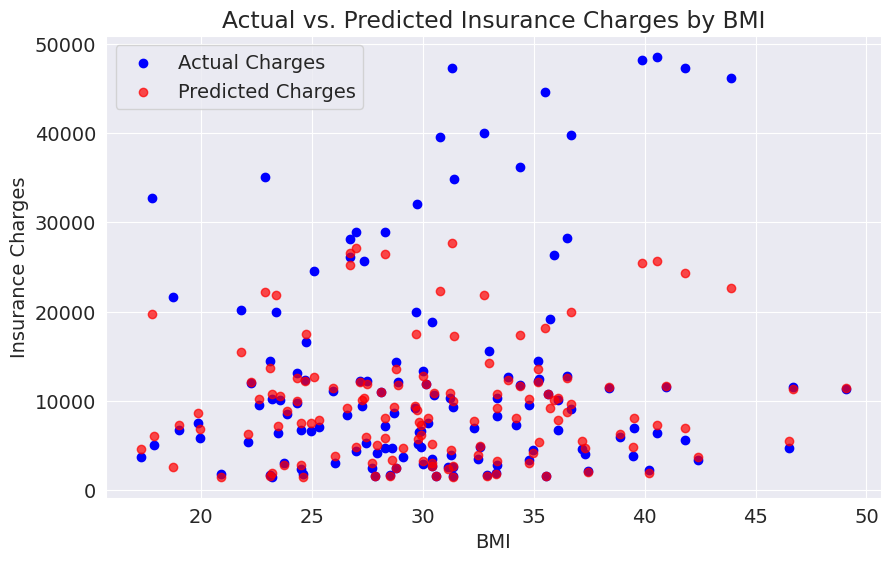

In [43]:
# Get the validation data
val_inputs, val_targets = validation_ds[:]
val_preds = model(val_inputs)

# Extract the BMI values from the inputs
bmi_values = val_inputs[:, 2].detach().numpy()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(bmi_values, val_targets.detach().numpy(), c='b', label='Actual Charges')
plt.scatter(bmi_values, val_preds.detach().numpy(), c='r', label='Predicted Charges', alpha=0.7)

# Add labels and title
plt.xlabel('BMI')
plt.ylabel('Insurance Charges')
plt.title('Actual vs. Predicted Insurance Charges by BMI')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
from sklearn.metrics import r2_score

# Calculate R-squared score
r2 = r2_score(val_targets.detach().numpy(), val_preds.detach().numpy())

print(f"R-squared (R²) Score: {r2:.4f}")

R-squared (R²) Score: 0.5990


# 6. Saving the model

In [46]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "insurance_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving Model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving Model to: models/insurance_model.pth


In [47]:
!ls  -l models

total 4
-rw-r--r-- 1 root root 1608 Jul 30 20:35 insurance_model.pth


# 7. Loading the model

In [48]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 2.5953e+02, -4.2876e+02, -9.6040e-01,  3.7511e+02,  1.3646e+04,
                       -2.2247e+02]])),
             ('linear.bias', tensor([-2670.7551]))])

In [49]:
model_loaded = InsuranceModel()
model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [50]:
model_loaded.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 2.5953e+02, -4.2876e+02, -9.6040e-01,  3.7511e+02,  1.3646e+04,
                       -2.2247e+02]])),
             ('linear.bias', tensor([-2670.7551]))])